In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

# MINE Ablation Study

Code is taken from MINE implementation directly and some additional changes added

In [2]:
class MineELU(nn.Module):
    def __init__(self, input_size=2, hidden_size=100):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_out')
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.kaiming_normal_(self.fc2.weight, mode='fan_out')
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.kaiming_normal_(self.fc3.weight, mode='fan_out')
        nn.init.constant_(self.fc3.bias, 0)
        
    def forward(self, input_arg):
        output = F.elu(self.fc1(input_arg))
        output = F.elu(self.fc2(output))
        output = self.fc3(output)
        return output
    
class MineReLU(nn.Module):
    def __init__(self, input_size=2, hidden_size=100):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.kaiming_normal_(self.fc2.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.kaiming_normal_(self.fc3.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(self.fc3.bias, 0)
        
    def forward(self, input_arg):
        output = F.elu(self.fc1(input_arg))
        output = F.elu(self.fc2(output))
        output = self.fc3(output)
        return output
    
def mutual_information(joint, marginal, mine_net):
    t = mine_net(joint)
    et = torch.exp(mine_net(marginal))
    mi_lb = torch.mean(t) - torch.log(torch.mean(et))
    return mi_lb, t, et

def learn_mine(batch, mine_net, mine_net_optim,  ma_et, ma_rate=0.01):
    # batch is a tuple of (joint, marginal)
    joint , marginal = batch
    joint = torch.autograd.Variable(torch.FloatTensor(joint))
    marginal = torch.autograd.Variable(torch.FloatTensor(marginal))
    mi_lb, t, et = mutual_information(joint, marginal, mine_net)
    ma_et = (1-ma_rate)*ma_et + ma_rate*torch.mean(et)
    
    # unbiasing use moving average
    loss = -(torch.mean(t) - (1/ma_et.mean()).detach()*torch.mean(et))
    # use biased estimator
#     loss = - mi_lb
    
    mine_net_optim.zero_grad()
    autograd.backward(loss)
    mine_net_optim.step()
    return mi_lb, ma_et

def sample_batch(data, batch_size, sample_mode='joint'):
    if sample_mode == 'joint':
        index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        batch = data[index]
    else:
        joint_index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        marginal_index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        batch = np.concatenate([data[joint_index][:,0].reshape(-1,1),
                                         data[marginal_index][:,1].reshape(-1,1)],
                                       axis=1)
    return batch

def train(data, mine_net,mine_net_optim, batch_size=100, iter_num=int(1e+5), log_freq=int(1e+3)):
    # data is x or y
    result = list()
    ma_et = 1.
    for i in range(iter_num):
        batch = sample_batch(data, batch_size), sample_batch(data, batch_size, sample_mode='marginal')
        mi_lb, ma_et = learn_mine(batch, mine_net, mine_net_optim, ma_et)
        result.append(mi_lb.item())
        if (i+1) % log_freq == 0:
            print(result[-1]) 
    result = np.asarray(result)
    return result

def ma(a, window_size=100):
    return [np.mean(a[i:(i+window_size)]) for i in range(0,len(a)-window_size)]

covariance used in all experiments is selected as 0.8 which is equal to correlation. The relationship between correlation and mutual information is the following for gaussian multivariate random variables [ref](https://lips.cs.princeton.edu/correlation-and-mutual-information/):

\begin{equation*}
    I(X, Y) = -\frac{1}{2}\ln(1 - Corr(X, Y)^2)
\end{equation*}

Therefore, the mutual information $I(X, Y) = 0.51082562376$

In [3]:
cov = [
    [1., .8],
    [.8, 1.]
]

## Sample size effects the performance of the model

**The most the sample size is the better performance results taken from the model.** For the ablation study the following sample sizes are tested with 128 as a batch size and ELU as an activation function using the given MINE model: [128, 256, 512, 1024, 2048]

In [55]:
def plot_sample_size_graphs(results):
    plt.rcParams['figure.dpi']=300
    plt.figure(figsize=(20, 5))
    result_cor_ma = ma(results)
    plt.plot(range(len(result_cor_ma)), result_cor_ma, label='Estimations')
    plt.hlines(0.51082562376, 0, len(result_cor_ma), colors='red', label='Expected mutual information')
    plt.scatter(len(result_cor_ma), result_cor_ma[-1], c='white', zorder=100, label='Final estimation')
    plt.annotate('{:.2f}'.format(result_cor_ma[-1]), (len(result_cor_ma), result_cor_ma[-1]), fontsize=5, zorder=200)
    z = np.polyfit(range(len(result_cor_ma)), result_cor_ma, 2)
    p = np.poly1d(z)
    plt.plot(range(len(result_cor_ma)), p(range(len(result_cor_ma))), label='Trend line of estimations')
    plt.legend()
    plt.ylabel('Mutual information')
    plt.xlabel('# of iterations')

In [5]:
data_X = np.random.multivariate_normal(mean=[0,0], cov=cov, size=128)
mine_net_cor = MineELU()
mine_net_optim_cor = optim.Adam(mine_net_cor.parameters(), lr=1e-3)
result_cor = train(data_X, mine_net_cor, mine_net_optim_cor, batch_size=128)

0.5174359679222107
0.6192241907119751
0.4443202018737793
0.6541152596473694
0.42226406931877136
0.6321029663085938
0.5576659440994263
0.5310984253883362
0.6031786799430847
0.4350043833255768
0.5376700758934021
0.6125888824462891
0.6717621088027954
0.4570312798023224
0.6255371570587158
0.576338529586792
0.4042779207229614
0.7015858888626099
0.4649334251880646
0.22060635685920715
0.4313444495201111
0.6404873132705688
0.5385785698890686
0.5086642503738403
0.5130676627159119
0.4609013795852661
0.630570650100708
0.649039626121521
0.6963651776313782
0.5794291496276855
0.508107602596283
0.5958725810050964
0.46548962593078613
0.5723614692687988
0.697933554649353
0.5613113045692444
0.7144530415534973
0.5625707507133484
0.5349416732788086
0.6087672114372253
0.35338783264160156
0.6004985570907593
0.49364978075027466
0.49920952320098877
0.5345624089241028
0.5740072727203369
0.6490533947944641
0.6393418312072754
0.518110990524292
0.6631256341934204
0.6607029438018799
0.5359517335891724
0.5876714587

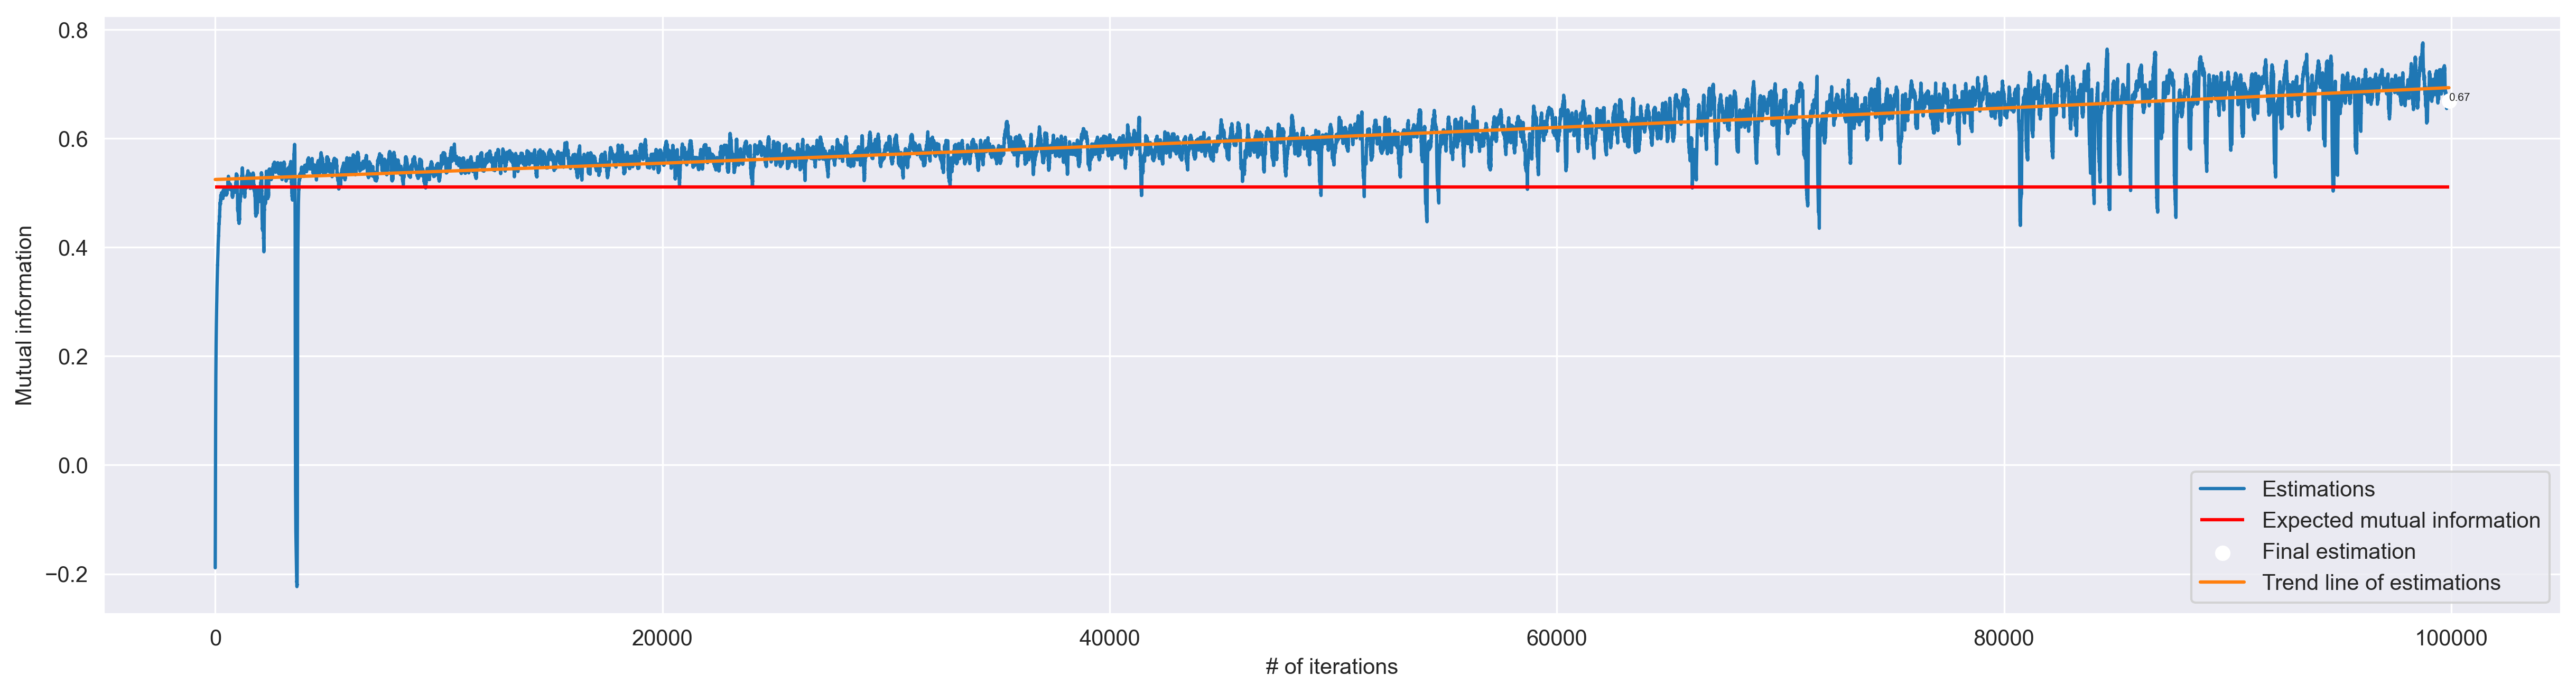

In [56]:
plot_sample_size_graphs(result_cor)